In [3]:
import keras
import tensorflow as tf

In [11]:
keras.__version__, tf.__version__

('3.3.0.dev2024042203', '2.17.0-dev20240422')

In [41]:
import pandas as pd
import numpy as np


from keras.optimizers import Adam
from keras.optimizers.schedules import PolynomialDecay
from keras.callbacks import EarlyStopping
from keras.preprocessing import timeseries_dataset_from_array
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.losses import MeanSquaredError as loss_mse
from keras.metrics import RootMeanSquaredError, MeanSquaredError
from keras.backend import clear_session

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline # pipeline으로 이어지는 작업을 하나로 묶어서 사용
from sklearn.compose import ColumnTransformer # 데이터 전처리에 사용
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns


In [16]:
data_url = 'https://drive.google.com/uc?id=1ZpgpKUKi-tJc6e0TxZcqcA-HfRHqs55N'
data = pd.read_csv(data_url)
data.head(10)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0


In [17]:
data['Date Time'] = pd.to_datetime(data['Date Time'], format='mixed')
data[data['Date Time'].dt.minute==0]

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70
11,2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.30
17,2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.20
23,2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.00
29,2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420526,2016-12-31 20:00:00,1001.47,-1.52,271.52,-7.13,65.42,5.46,3.57,1.89,2.22,3.57,1282.60,1.24,1.96,232.00
420532,2016-12-31 21:00:00,1001.29,-3.09,269.98,-7.09,73.70,4.86,3.58,1.28,2.23,3.58,1289.78,0.61,1.48,207.50
420538,2016-12-31 22:00:00,1000.70,-2.59,270.51,-7.04,71.30,5.04,3.60,1.45,2.24,3.59,1286.67,0.38,0.72,8.15
420544,2016-12-31 23:00:00,1000.21,-3.76,269.39,-7.95,72.50,4.62,3.35,1.27,2.09,3.35,1291.71,0.89,1.30,223.70


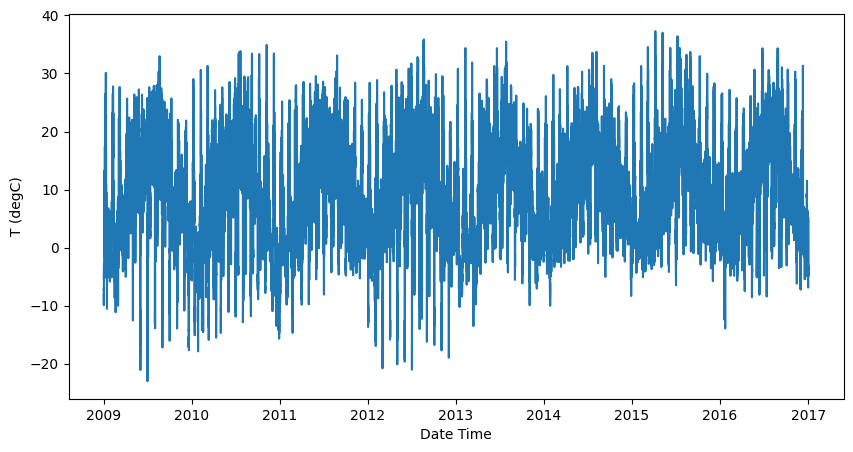

In [18]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=data, x='Date Time', y='T (degC)')

plt.show()

In [19]:
data = data[data['Date Time'].dt.minute==0].reset_index(drop=True).drop(columns=['Tpot (K)', 'Tdew (degC)'])

In [22]:
# target과 input 분리

input_ = data.drop(['Date Time', 'T (degC)'], axis=1)
target = data['T (degC)'].to_numpy().reshape(-1, 1)

In [25]:
# scaling data
preprocessing = ColumnTransformer([
    ('scaling', StandardScaler(), list(input_.columns))
])

scaled_input = preprocessing.fit_transform(input_)

target_scaler = StandardScaler()
scaled_target = target_scaler.fit_transform(target)

print(scaled_input.shape, scaled_target.shape)

(70092, 11) (70092, 1)


In [26]:
x_train, x_valid, y_train, y_valid = train_test_split(scaled_input, scaled_target, test_size=.2, shuffle=False, random_state=2024)

In [28]:
help(timeseries_dataset_from_array)

Help on function timeseries_dataset_from_array in module keras.src.utils.timeseries_dataset_utils:

timeseries_dataset_from_array(data, targets, sequence_length, sequence_stride=1, sampling_rate=1, batch_size=128, shuffle=False, seed=None, start_index=None, end_index=None)
    Creates a dataset of sliding windows over a timeseries provided as array.

    This function takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    length of the sequences/windows, spacing between two sequence/windows, etc.,
    to produce batches of timeseries inputs and targets.

    Args:
        data: Numpy array or eager tensor
            containing consecutive data points (timesteps).
            Axis 0 is expected to be the time dimension.
        targets: Targets corresponding to timesteps in `data`.
            `targets[i]` should be the target
            corresponding to the window that starts at index `i`
            (see example 2 below).
  

In [47]:
# window = 24. artinya dalam 24 jam, kita mencoba untuk prediksi temperatur 1 jam berikutnya
window_len = 24
batch_size = 526
n_feature = x_train.shape[1]

train_gen = timeseries_dataset_from_array(
    data=x_train, 
    targets=y_train, 
    sequence_length=window_len, 
    shuffle=False, 
    batch_size=batch_size)

valid_gen = timeseries_dataset_from_array(
    data=x_valid, 
    targets=y_valid, 
    sequence_length=window_len, 
    shuffle=False, 
    batch_size=batch_size)

# test_gen=timeseries_dataset_from_array(
#     data=X_test_scaled, 
#     targets=y_test, 
#     length=window_len, 
#     shuffle=False, 
#     batch_size=batch_size)

In [48]:
clear_session()

il = Input(shape=(window_len, n_feature))
# x = LSTM(128, return_sequences=True, activation='tanh')(il)
# x = LSTM(64, return_sequences=True, activation='tanh')(x)

x = LSTM(64, return_sequences=True, activation='tanh')(il)
x = LSTM(32)(x)
# x = Dense(16, activation='relu')(x)
ol = Dense(1)(x)

model_lstm = Model(inputs=il, outputs=ol)
model_lstm.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 11)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 64)         │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,905 (124.63 KB)

 Trainable params: 31,905 (124.63 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# learning rate scheduler
num_epochs = 30
num_train_steps = n_feature * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate=1e-3, 
                            #    end_learning_rate=0.0, 
                               decay_steps=num_train_steps)

model_lstm.compile(loss=loss_mse(),
              optimizer=Adam(learning_rate=lr_scheduler),
              metrics=[RootMeanSquaredError()])

In [51]:
early_stopping = EarlyStopping(monitor='val_loss',
                              patience= 3,
                              restore_best_weights=True,
                              verbose=0)

In [52]:
history = model_lstm.fit(
    x=train_gen,
    validation_data = valid_gen,
    shuffle=False,
    callbacks = [early_stopping],
    batch_size = batch_size,
    epochs = num_epochs
).history

Epoch 1/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.5007 - root_mean_squared_error: 0.6774 - val_loss: 0.1479 - val_root_mean_squared_error: 0.3846
Epoch 2/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.1422 - root_mean_squared_error: 0.3760 - val_loss: 0.0989 - val_root_mean_squared_error: 0.3145
Epoch 3/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.1115 - root_mean_squared_error: 0.3321 - val_loss: 0.0865 - val_root_mean_squared_error: 0.2941
Epoch 4/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0898 - root_mean_squared_error: 0.2991 - val_loss: 0.0824 - val_root_mean_squared_error: 0.2871
Epoch 5/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0839 - root_mean_squared_error: 0.2891 - val_loss: 0.0777 - val_root_mean_squared_error: 0.2788
Epoch 6/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0787 - root_mean_squared_error: 0.2801 - val_loss: 0.0727 - val_root_mean_squared_error: 0.2695
Epoch 7/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 44m

In [53]:
pred = model_lstm.predict(valid_gen).flatten()

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [59]:

pred.shape[0] - y_valid.shape[0]

-23